In [1]:
from itertools import islice

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

import pandas as pd
import numpy as np
from sklearn.manifold import TSNE

In [5]:
from gluonts.dataset.repository.datasets import get_dataset
from gluonts.dataset.common import MetaData, FileDataset
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.torch.distributions import NegativeBinomialOutput

from pytorch_lightning.loggers import CSVLogger

from model import VQTrEstimator

In [6]:
 meta = MetaData.parse_file("/home/kashif/.mxnet/gluon-ts/datasets/m5/metadata.json")

In [7]:
train_ds = FileDataset(
        path="/home/kashif/.mxnet/gluon-ts/datasets/m5/train", 
        freq=meta.freq
    )

val_ds = FileDataset(
        path="/home/kashif/.mxnet/gluon-ts/datasets/m5/val", 
        freq=meta.freq,
    )

test_ds = FileDataset(
        path="/home/kashif/.mxnet/gluon-ts/datasets/m5/test", 
        freq=meta.freq,
    )

In [10]:
estimator = VQTrEstimator(
        freq=meta.freq,
        prediction_length=meta.prediction_length,
        context_length=meta.prediction_length*6,
        codebook_size=128,
        scaling=True,
        depth=2,
        nhead=4,
        dim_head=8,
        num_encoder_layers=4,
        num_decoder_layers=4,
        dim_feedforward=32,
        num_feat_dynamic_real=len(meta.feat_dynamic_real),
        num_feat_static_cat=len(meta.feat_static_cat),
        cardinality=[int(cat_feat_info.cardinality) for cat_feat_info in meta.feat_static_cat],
        embedding_dimension = [4, 4, 4, 4, 8],
        batch_size=256,
        num_batches_per_epoch=128,
        distr_output=NegativeBinomialOutput(),
        #distr_output=ImplicitQuantileNetworkOutput("positive"),
        #loss=QuantileLoss(),
        trainer_kwargs=dict(max_epochs=100, logger=CSVLogger(".", "lightning_logs/")),
    )

In [ ]:
predictor = estimator.train(
        training_data=train_ds,
        validation_data=val_ds,
        shuffle_buffer_length=2048,
        cache_data=True,
    )

/home/kashif/.env/pytorch/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/kashif/.env/pytorch/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory ./lightning_logs/version_0/check

Sanity Checking: 0it [00:00, ?it/s]

/home/kashif/.env/pytorch/lib/python3.10/site-packages/torch/nn/modules/activation.py:1186: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at ../aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._native_multi_head_attention(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0, global step 128: 'val_loss' reached 1.54072 (best 1.54072), saving model to './lightning_logs/version_0/checkpoints/epoch=0-step=128.ckpt' as top 1


In [8]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,
    predictor=predictor,
)

In [9]:
forecasts = list(forecast_it)

/home/kashif/gluon-ts-PR/src/gluonts/dataset/common.py:321: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(string, freq=freq)
/home/kashif/gluon-ts-PR/src/gluonts/dataset/common.py:324: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/home/kashif/gluon-ts-PR/src/gluonts/dataset/common.py:326: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  timestamp.floor(timestamp.freq), timestamp.freq
/home/kashif/gluon-ts-PR/src/gluonts/dataset/common.py:325: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  return pd.Timestamp(
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/sr

In [10]:
tss = list(ts_it)

In [24]:
evaluator = Evaluator(quantiles=(np.arange(20)/20.0)[1:])

In [25]:
agg_metrics, ts_metrics = evaluator(iter(tss), iter(forecasts))

Running evaluation: 30490it [00:00, 71089.07it/s]/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:306: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.index[0].freq
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:306: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.index[0].freq
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:306: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.index[0].freq
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:306: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.index[0].freq
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:306: FutureWarning: Timestamp.freq

In [26]:
agg_metrics # 

{'MSE': 5.693734283008085,
 'abs_error': 859256.0,
 'abs_target_sum': 1229142.0,
 'abs_target_mean': 1.4397483952583983,
 'seasonal_error': 1.129429940564359,
 'MASE': 0.9083333790984478,
 'MAPE': 0.7785903515440432,
 'sMAPE': 1.5607897198676928,
 'MSIS': 7.524725152758517,
 'QuantileLoss[0.05]': 134751.3,
 'Coverage[0.05]': 0.005890690156023051,
 'QuantileLoss[0.1]': 250251.20000000007,
 'Coverage[0.1]': 0.011237876587171437,
 'QuantileLoss[0.15]': 357095.7,
 'Coverage[0.15]': 0.018694653984913087,
 'QuantileLoss[0.2]': 455746.80000000005,
 'Coverage[0.2]': 0.02822471067797404,
 'QuantileLoss[0.25]': 546368.0,
 'Coverage[0.25]': 0.04060230520545377,
 'QuantileLoss[0.3]': 628312.2,
 'Coverage[0.3]': 0.05582392353464835,
 'QuantileLoss[0.35]': 701241.2,
 'Coverage[0.35]': 0.07484655390526167,
 'QuantileLoss[0.4]': 764638.7999999999,
 'Coverage[0.4]': 0.09819847256711801,
 'QuantileLoss[0.45]': 817539.3999999999,
 'Coverage[0.45]': 0.1260588951881179,
 'QuantileLoss[0.5]': 859256.0,
 'Co

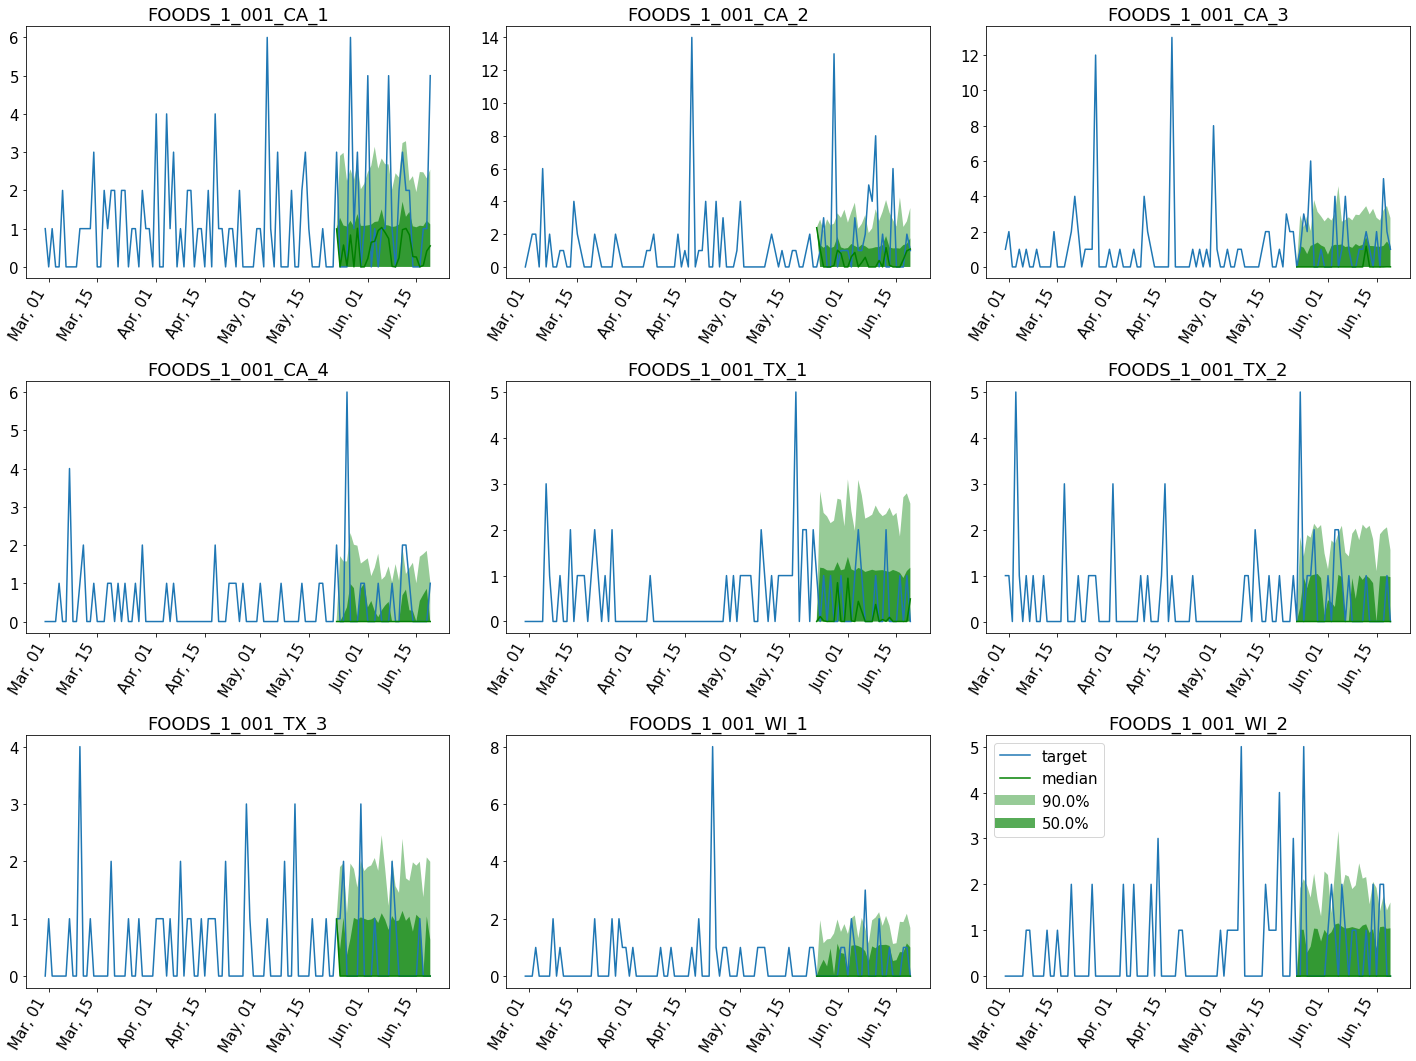

In [16]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)

    plt.plot(ts[-4 * meta.prediction_length:], label="target", )
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)
plt.gcf().tight_layout()
plt.legend()
plt.show()

NameError: name 'dataset' is not defined

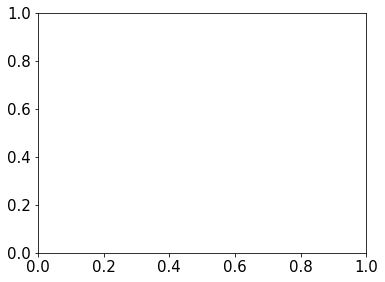

In [15]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)

    plt.plot(ts[-4 * dataset.metadata.prediction_length:], label="target", )
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

In [17]:
metrics = pd.read_csv("lightning_logs/version_110/metrics.csv")

In [18]:
metrics

,train_perplexity,epoch,step,val_loss,train_loss
0,3.329596,0,49,NaN,NaN
1,4.412152,0,99,NaN,NaN
2,NaN,0,127,0.358333,NaN
3,NaN,0,127,NaN,0.469539
4,5.484507,1,149,NaN,NaN
...,...,...,...,...,...
451,106.229691,99,12699,NaN,NaN
452,104.311523,99,12749,NaN,NaN
453,102.154739,99,12799,NaN,NaN
454,NaN,99,12799,0.305164,NaN


Text(0, 0.5, 'perplexity')

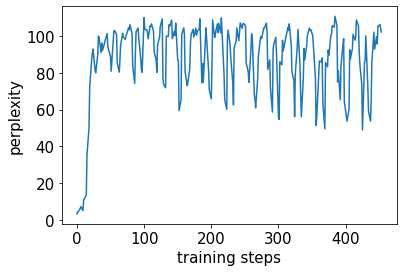

In [19]:
ax = metrics.train_perplexity.dropna().plot(kind="line")
ax.set_xlabel("training steps")
ax.set_ylabel("perplexity")

<AxesSubplot:>

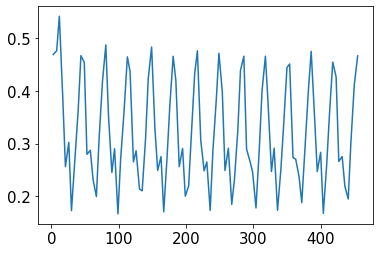

In [20]:
metrics.train_loss.dropna().plot()

In [21]:
X = predictor.prediction_net.vq_vae.embed.cpu()

In [22]:
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(X)

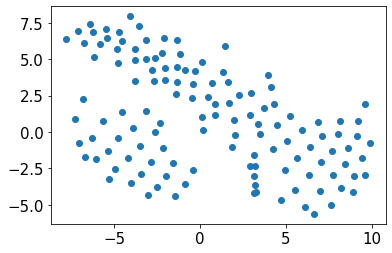

In [23]:
plt.scatter(X_embedded[:,0], X_embedded[:,1], alpha=1.0)